**Assignment 3 Solution**<br>
Import Required Libraries

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import math
import random
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Creating Lunar Lander environment

In [3]:
env = gym.make('LunarLander-v3')

Set device (gpu if available or else cpu)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Transition maps state, action pair to next state and reward

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

Creating ReplayMemory for experience replay (better model)

In [6]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity) #using deque as we need to remove the oldest memory and add new ones
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

Creating DQN class with two hidden layers each having 128 neurons

In [7]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(state_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action_size)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Parameters for DQN

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPSILON_START = 0.9
EPSILON_END = 0.1
EPSILON_DECAY = 1000
TAU = 0.005
lr =1e-4

Storing state size, action size

In [9]:
n_actions = env.action_space.n #using env.action_space.n since action size is discrete
state, info = env.reset()
n_observations = len(state)

Creating Policy Network, Target Network

In [10]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # making weights of target network equal of that of policy network

<All keys matched successfully>

Setting Optimizer and memory of capacity `100000`

In [11]:
optimizer = optim.AdamW(policy_net.parameters(), lr=lr)
memory = ReplayMemory(100000)

`steps_done` counts overall steps done

In [12]:
steps_done = 0

`select_action` function selects action to be taken with epsilon greedy algorithm

In [13]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY) #Exponentially decaying epsilon-greedy exploration
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device) #random action selection

A list of Total Reward of each episode

In [14]:
episode_reward = []

`plot` function to plot final result of training

In [15]:
def plot():
    plt.figure(1)
    total_reward = torch.tensor(episode_reward, dtype=torch.float)
    plt.title('Result')
    plt.xlabel('Episode')
    plt.ylabel('Total_Reward')
    plt.ylim(-100,350)
    plt.plot(total_reward.numpy())

`optimize` function to optimize the DQN

In [16]:
def optimize():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    expected_state_action_values = reward_batch + GAMMA * next_state_values #bellman equation
    
    criterion = nn.SmoothL1Loss() #Huber Loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1)) # unsqueeze for changing dimension
    
    optimizer.zero_grad()
    loss.backward() #backpropogation
    
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Storing maximum Total Reward achieved during training

In [17]:
max_treward = 0

Running 1000 iterations of environment to train model

In [17]:
for i_episode in range(1000):
    treward = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while True:
        action = select_action(state)
        observation, rewardn, terminated,_ ,_= env.step(action.item())
        reward = torch.tensor([rewardn], device=device)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float, device=device).unsqueeze(0)
        treward += rewardn
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize()
        #updating target network slowly
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1 - TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if terminated:
            if treward >= max_treward and treward >= 200: #treward >=200 since it is required condition for a valid solution as given in gymnasium documentation
                max_treward = treward
                print('GOOD EPISODE: \n Total Reward:', max_treward)
                torch.save(policy_net.state_dict(), './policy_net_max.pth') #saving Policy Network with maximum reward
            episode_reward.append(treward)
            break

GOOD EPISODE: 
 Total Reward: 201.14286403712768
GOOD EPISODE: 
 Total Reward: 252.28151555837553
GOOD EPISODE: 
 Total Reward: 269.2808679406512
GOOD EPISODE: 
 Total Reward: 270.66943044402865
GOOD EPISODE: 
 Total Reward: 273.063498851668
GOOD EPISODE: 
 Total Reward: 294.2192936817154
GOOD EPISODE: 
 Total Reward: 299.47901512164447
GOOD EPISODE: 
 Total Reward: 312.9328378789752
GOOD EPISODE: 
 Total Reward: 316.6551339043914


Training Result

Finished Training
Max Total reward:  316.6551339043914
Final Total reward:  287.1260325881574


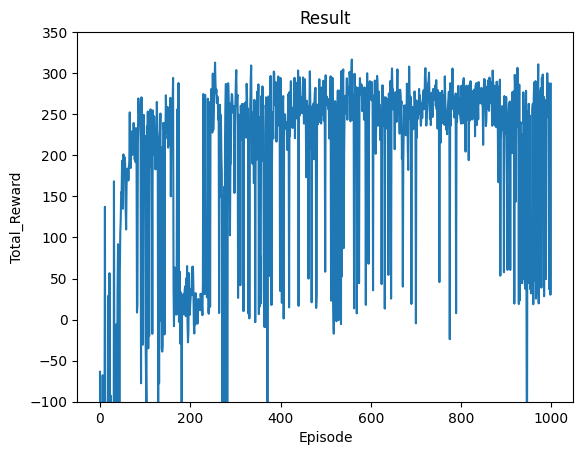

In [54]:
print('Finished Training')
torch.save(policy_net.state_dict(), './policy_net_final.pth')
plot()
print("Max Total reward: ", max_treward)
print('Final Total reward: ', episode_reward[-1])

Testing the Policy Network having maximum Total Reward

In [20]:
#inference
env = gym.make('LunarLander-v3',render_mode = 'human') #render_mode = human creates a pygame window for simulation
state, info = env.reset()
model = DQN(n_observations, n_actions)
model.load_state_dict(torch.load("./policy_net_max.pth", weights_only=True))
model.eval()
terminated = False
trewardinf = 0
while not terminated:
    state = torch.tensor(state, dtype=torch.float32, device='cpu').unsqueeze(0)
    action = model(state).max(1).indices.view(1,1)  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action.item())
    trewardinf += reward
    state = observation
env.close()
print(trewardinf)

274.3579608900477
